In [1]:
import numpy as np
import pickle
from pandas import DataFrame, read_csv
from sklearn import metrics as met
import warnings
import tensorflow as tf
from tensorflow.contrib import rnn
import matplotlib.pyplot as plt
from matplotlib import gridspec
from tensorflow import nn 
import helperModule as hm
import helperModule as hm2


warnings.filterwarnings("ignore")
%config InlineBackend.figure_format = 'retina'

In [2]:
#########################
############ Read in data
#########################

data = pickle.load( open( "kdd99.p", "rb" ) )

x_train = data['x_train']
x_test = data['x_test']
y_train = data['y_train']
y_test = data['y_test']

In [44]:
n_features = 41 # KDD99 data input (41 features)
n_classes = 5 # KDD99 labels (5 types of connection)
st_dev = 0.2
n_hidden_1 = 128
n_hidden_2 = 128
learning_rate = 0.01

training_iters = 5000000
batch_size = 256
display_step = 50
display_testing_step = 200



In [4]:
tf.reset_default_graph()

# tf Graph input
x = tf.placeholder("float", [None, n_features])
y = tf.placeholder("float", [None, n_classes])
keep_prob = tf.placeholder(tf.float32, name='keep_prob')

# Define weights
W = {
    'h1': tf.Variable(tf.random_normal([n_features, n_hidden_1], stddev=st_dev)),
    'h2': tf.Variable(tf.random_normal([n_hidden_1, n_hidden_2], stddev=st_dev)),
    'out': tf.Variable(tf.truncated_normal([n_hidden_2, n_classes], stddev=st_dev))
}

b = {
    'b1': tf.Variable(tf.random_normal([n_hidden_1])),
    'b2': tf.Variable(tf.random_normal([n_hidden_2])),
    'out': tf.Variable(tf.zeros([n_classes]))
}

In [5]:
def basic_neural_network(x, W, b):
    # Hidden layer with RELU activation
    hidden_1 = tf.add(tf.matmul(x, W['h1']), b['b1'])
    hidden_1 = tf.nn.relu(hidden_1)
    # Hidden layer with RELU activation
    hidden_2 = tf.add(tf.matmul(hidden_1, W['h2']), b['b2'])
    hidden_2 = tf.nn.relu(hidden_2)
    # Output layer with linear activation
    out_layer = tf.matmul(hidden_2, W['out']) + b['out']
    #out_layer = tf.nn.relu(out_layer)
    return out_layer

In [6]:
# Construct model
pred = basic_neural_network(x, W, b)

# Define loss and optimizer
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=pred, labels=y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

correct_pred = tf.equal(tf.argmax(pred,1), tf.argmax(y,1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

In [47]:


init = tf.global_variables_initializer()
losses = {'train':[], 'validation':[]}
# Launch the graph
with tf.Session() as sess:
    sess.run(init)
    step = 1
    # Keep training until reach max iterations
    while step * batch_size < training_iters:
        offset = (step * batch_size) % (y_train.shape[0] - batch_size)
        # Generate a minibatch.
        #print offset
        batch_x = x_train[offset:(offset + batch_size), :]
        batch_y = y_train[offset:(offset + batch_size), :]
        valid_x = x_train[:]
        valid_y = y_train[:]

        # Run optimization op (backprop)
        sess.run(optimizer, feed_dict={x: batch_x, y: batch_y})
        if step % display_step == 0:
            # Calculate batch accuracy
            #acc = sess.run(accuracy, feed_dict={x: batch_x, y: batch_y})
            acc = sess.run(accuracy, feed_dict={x: batch_x, y: batch_y})
            
            # Calculate batch loss
            loss_train = sess.run(cost, feed_dict={x: batch_x, y: batch_y})
            print("Iter " + str(step*batch_size) + ", Minibatch Loss= " + \
                  "{:.6f}".format(loss_train) + ", Training Accuracy= " + \
                  "{:.5f}".format(acc))
            
            #loss_valid = sess.run(cost, feed_dict={x:x_test , y: y_test})
            
            losses['train'].append(loss_train)
            #losses['validation'].append(loss_valid)
            
            
        step += 1
        
        if step % display_testing_step == 0:
        
            test_len = 20000
            test_data = x_test[:test_len]
            test_label = y_test[:test_len]
            print("Validation Accuracy:", sess.run(accuracy, feed_dict={x: test_data, y: test_label}))
        
                
    print("Optimization Finished!")

    
    y_pred = sess.run(tf.argmax(pred, 1), feed_dict={x:x_test})
    y_true = np.argmax(y_test,1)
    conf_matrix = met.confusion_matrix(y_true, y_pred)



Iter 12800, Minibatch Loss= 1.408106, Training Accuracy= 0.00000
Iter 25600, Minibatch Loss= 0.001729, Training Accuracy= 1.00000
Iter 38400, Minibatch Loss= 0.002562, Training Accuracy= 1.00000
('Validation Accuracy:', 0.98474997)
Iter 51200, Minibatch Loss= 1.304100, Training Accuracy= 0.00000
Iter 64000, Minibatch Loss= 0.000717, Training Accuracy= 1.00000
Iter 76800, Minibatch Loss= 0.011425, Training Accuracy= 1.00000
Iter 89600, Minibatch Loss= 0.010969, Training Accuracy= 1.00000
('Validation Accuracy:', 0.92629999)
Iter 102400, Minibatch Loss= 0.000150, Training Accuracy= 1.00000
Iter 115200, Minibatch Loss= 0.000261, Training Accuracy= 1.00000
Iter 128000, Minibatch Loss= 0.000075, Training Accuracy= 1.00000
Iter 140800, Minibatch Loss= 1.845427, Training Accuracy= 0.23047
('Validation Accuracy:', 0.98580003)
Iter 153600, Minibatch Loss= 0.007541, Training Accuracy= 1.00000
Iter 166400, Minibatch Loss= 0.000147, Training Accuracy= 1.00000
Iter 179200, Minibatch Loss= 0.000055,

In [1]:
plt.plot(losses['train'], label='Training loss')
#plt.plot(losses['validation'], label='Validation loss')
plt.legend()
_ = plt.ylim()
plt.show()

NameError: name 'plt' is not defined

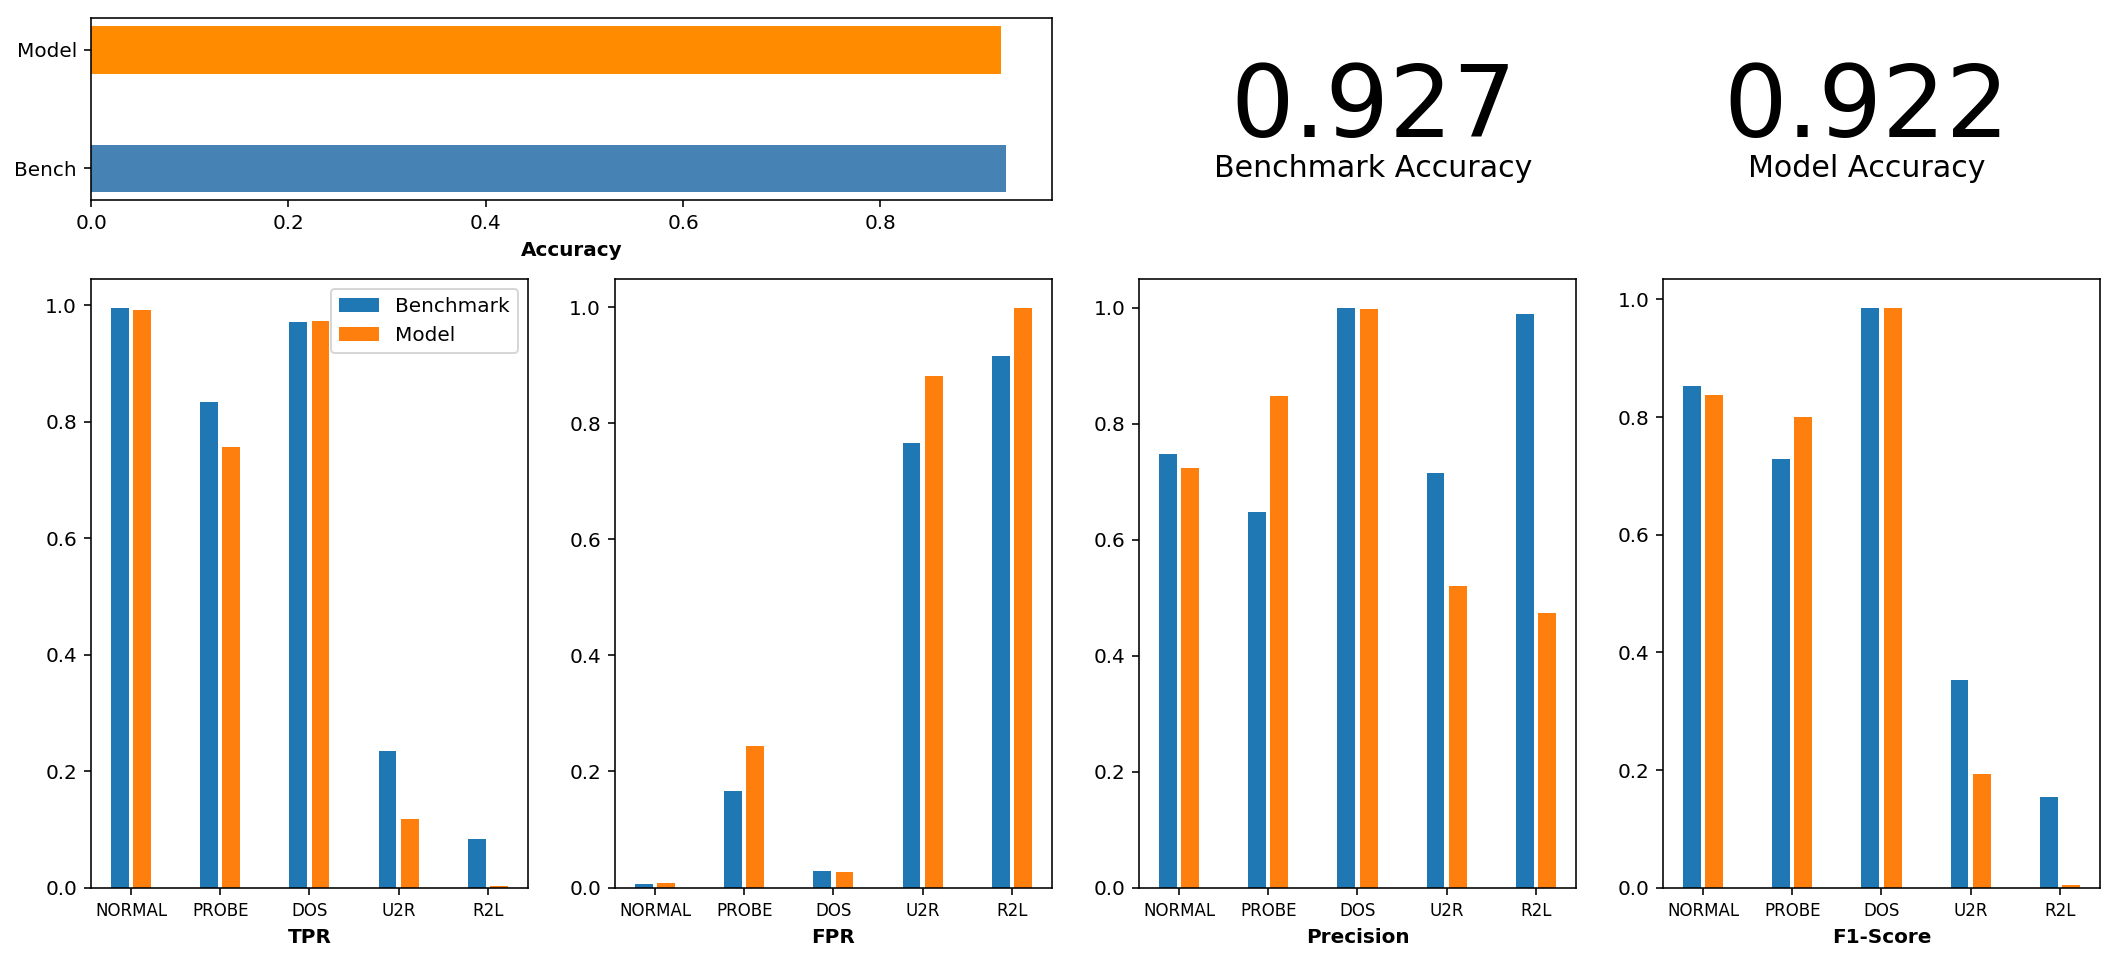

In [48]:
conf_bench = hm.getBenchmarkResults()
metrics = hm.computePerformanceMetrics(conf_bench, conf_matrix)
hm.plotMetrics(metrics)